# RASCIL Benchmark

Results from rascil MID simulation benchmarks.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
import modules

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Defined benchmarks

Currently, there is one MID simulation benchmark defined for two different dataset sizes.

The two different sizes namely, *small* and *large*. In the small dataset, there are only 8 frequency channels, where as in large dataset there are 100 frequency channels. The number of major/minor cycles are also different for small and large datasets. Please refer to `reframe_rascil.py` for benchmark configuration. The benchmark is designed based on the work [here](https://gitlab.com/ska-telescope/sim/ska-sim-mid/-/blob/sim-930_rerun_large_mid/continuum_imaging/sp-1331/image_B2_5km.sh).

## Latest run performance metrics

All the performance metrics are tabulated from the latest benchmark run for different systems/parititons and programming environments

### Small test case results
These results correspond to small image size of the benchmark. 

The table shows results for different systems/partition/environments, variant of benchmark, different number of cores and **small** sized benchmark

In [4]:
df = modules.utils.tabulate_last_perf(test='RascilTest*',
                                     root=PERFLOG_DIR,
                                     size='small')
df = df.transpose() # so now cols are all, single
display(df)

Empty DataFrame
Columns: []
Index: []

### Large test case results
These results correspond to small image size of the benchmark. 

The table shows results for different systems/partition/environments, variant of benchmark, different number of cores and **large** sized benchmark

In [5]:
df = modules.utils.tabulate_last_perf(test='RascilTest*',
                                     root=PERFLOG_DIR,
                                     size='very-large',
                                     extras=['num_nodes'])
df = df.transpose() # so now cols are all, single
df = df.sort_values(['case', 'num_nodes'])
display(df)

perf_var                                                     Create block visibilities time  \
case                                              num_nodes                                   
jacamar-hpc-ci:grvingt-gcc9-ompi4-opa-umod:rascil 8                                 565.691   
nancy-g5k:gros-gcc9-ompi4-eth-umod:rascil         8                                 793.336   
                                                  16                               3818.950   
                                                  32                               8370.570   
                                                  64                                    NaN   

perf_var                                                     Image deconvolution time  \
case                                              num_nodes                             
jacamar-hpc-ci:grvingt-gcc9-ompi4-opa-umod:rascil 8                          1883.600   
nancy-g5k:gros-gcc9-ompi4-eth-umod:rascil         8                          2614.020   
                                                  16                          403.262   
                                                  32                          314.229   
                                                  64                           70.090   

perf_var                                                     Imaging grid weights time  \
case                                              num_nodes                              
jacamar-hpc-ci:grvingt-gcc9-ompi4-opa-umod:rascil 8                             23.198   
nancy-g5k:gros-gcc9-ompi4-eth-umod:rascil         8                             19.918   
                                                  16                            39.660   
                                                  32                            79.843   
                                                  64                               NaN   

perf_var                                                     Imaging time  \
case                                              num_nodes                 
jacamar-hpc-ci:grvingt-gcc9-ompi4-opa-umod:rascil 8                8973.0   
nancy-g5k:gros-gcc9-ompi4-eth-umod:rascil         8                7313.0   
                                                  16               3503.0   
                                                  32               2073.0   
                                                  64               1933.0   

perf_var                                                     Skymodel invert time  \
case                                              num_nodes                         
jacamar-hpc-ci:grvingt-gcc9-ompi4-opa-umod:rascil 8                       2658.70   
nancy-g5k:gros-gcc9-ompi4-eth-umod:rascil         8                       2046.49   
                                                  16                      4192.23   
                                                  32                      7930.99   
                                                  64                     12098.50   

perf_var                                                     Skymodel predict time  \
case                                              num_nodes                          
jacamar-hpc-ci:grvingt-gcc9-ompi4-opa-umod:rascil 8                        2045.04   
nancy-g5k:gros-gcc9-ompi4-eth-umod:rascil         8                        1559.61   
                                                  16                       2995.22   
                                                  32                       5987.82   
                                                  64                      10558.60   

perf_var                                                     Total processing time  \
case                                              num_nodes                          
jacamar-hpc-ci:grvingt-gcc9-ompi4-opa-umod:rascil 8                       7843.957   
nancy-g5k:gros-gcc9-ompi4-eth-umod:rascil         8                       7481.832

## Scalability results

The plot shows the scalability of the benchmark when running on different number of cores on different system/partition/environment combination. The results are only for the **latest** tests

In [6]:
# Drive function to plot scalability results
def plot_scalability_tests(size, perf_vars):
    def set_axis_labels(ax, ya_name):
        ax.set_xlabel('Number of cores')
        ax.set_ylabel(ya_name)
        ax.grid()
    perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, test='RascilTest*', last=True)
    if perf_records is None:
        print('%s: no performance logs found' % test)
    nperf_vars = len(perf_vars)
    fig, ax = plt.subplots(nrows=1, ncols=nperf_vars, sharex=True, figsize=(6 * nperf_vars, 6))
    fig.suptitle("{} size".format(size), fontsize=14)
    for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
        # filter to only Gflops records (might have others)
        for iperf_var, perf_var in enumerate(perf_vars):
            data_dg = data.loc[(data['perf_var'] == perf_var) & (data['size'] == size)]
            data_dg = data_dg.sort_values('num_cores')
            data_dg.plot(ax=ax[iperf_var], x='num_cores', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)
            set_axis_labels(ax[iperf_var], perf_var)
            handles, labels = ax[iperf_var].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc='upper left')

### Large test case

The following results show scalability for dry-test benchmarks

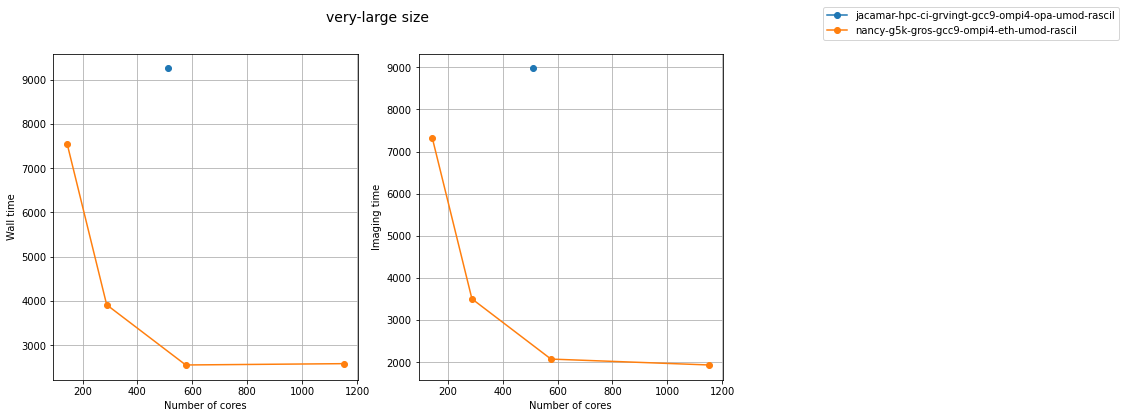

In [7]:
plot_scalability_tests(size='very-large', perf_vars=['Wall time', 'Imaging time'])

## Performance History

The plot shows the Degrid rate, write and read bandwidths for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

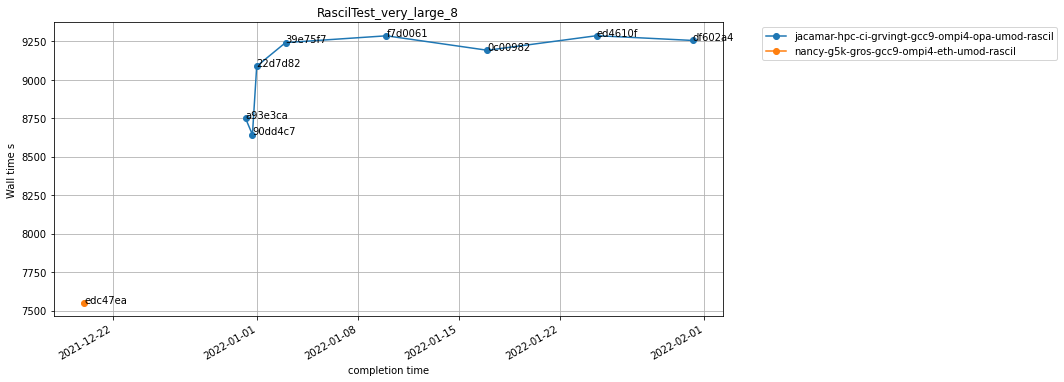

In [8]:
test='RascilTest_very_large_8'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
    # filter to only Gflops records (might have others)
    data = data.loc[data['perf_var'] == 'Wall time']
    data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

    # annotate points with git_ref:
    for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
        if not pd.isnull(ref):
            ax.annotate(ref[:7], (x, y))
ax.set_title(test)
ax.set_xlabel('completion time')
ax.set_ylabel('Wall time s')
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')